In this notebook we'll explore the solution found by our classifier.

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

import utils
import rnn

%load_ext autoreload
%matplotlib inline

Using TensorFlow backend.


In [2]:
%autoreload
import utils
import rnn

### Re-create the training data using saved model params

In [3]:
# Pick a model to load and extract the hyperparams.

model_name = 'models/256_1_256_256_0.5_False_20_6747_64_1_tanh_001_0.53317_0.73567_cleaned.h5'

gru_dim, num_gru, embed_dim, dense_dim, dropout, bidirectional, maxlen, topn, batch_size, output_size, gru_activation = \
  utils.parse_model_name(model_name)
    
# Load the keras model
model = load_model(model_name)

In [4]:
filepath = '../data/title-1-True-clean.pkl'

df, keep_stops, min_sents, vocab, w2i, i2w = utils.read_dataset(filepath)

In [5]:
# Filter out uncommon words using parameters parsed from model name.

df['encoded_text'] = utils.filter_top_words(df['encoded_text'].tolist(), topn)

In [6]:
# Create input/output data

X = pad_sequences(df['encoded_text'], maxlen=maxlen, value=topn, 
                  padding='post', truncating='post')

Y = df['encoded_label'].tolist()

### High-level view of data

In [7]:
# Get output probabilities for every observation.

df['prob'] = model.predict(X)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


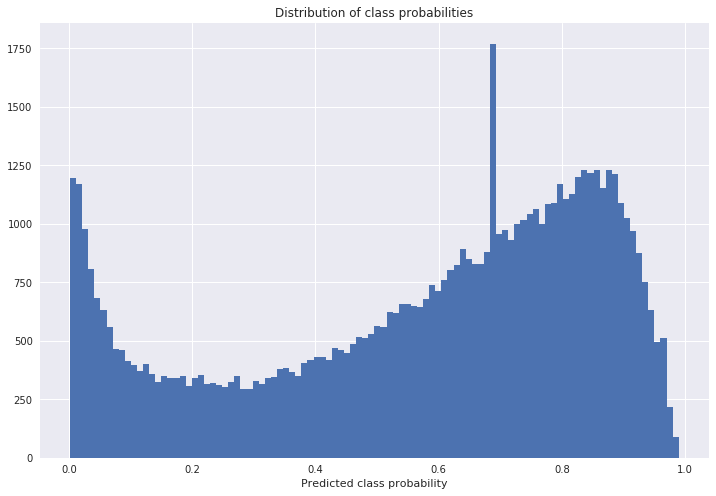

In [8]:
# Look at distribution.  There are some funny extreme modes we should try to understand.

fig, ax = plt.subplots()
ax.set_xlabel('Predicted class probability')
ax = df['prob'].hist(bins=100, figsize=(12, 8), ax=ax)
ax = ax.set_title('Distribution of class probabilities')

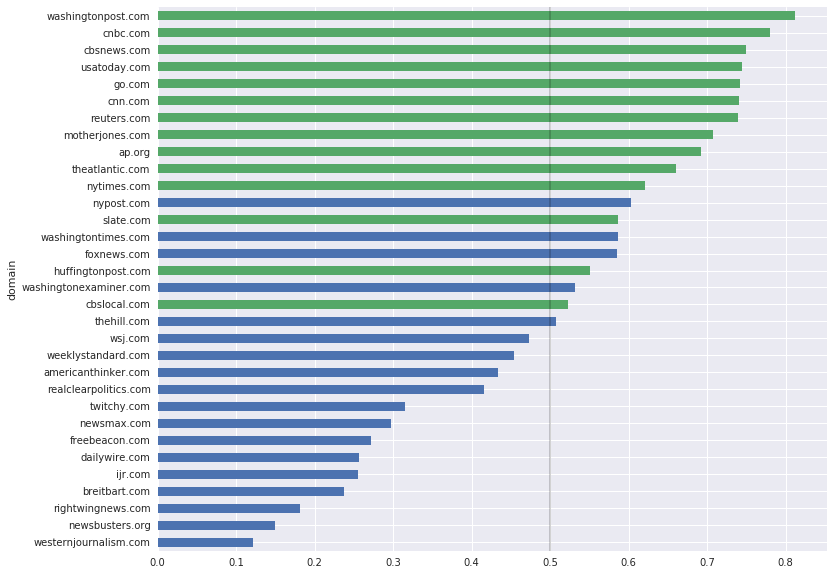

In [9]:
# Groupby domain name and take the average probability.  We can then round to 0/1 to 
# get a domain-level classification.

drop_less_than = 10  # Drop domains with fewer than this many observations

df_mean = df.groupby('domain')['encoded_label', 'prob'].mean()
df_count = df.groupby('domain')['domain'].count()
df_stats = pd.concat([df_mean, df_count], axis=1).sort_values('prob')
df_stats['num_correct'] = df_stats.apply(lambda x: int(np.round(x['prob'])) == x['encoded_label'], axis=1)
df_stats = df_stats[df_stats['domain'] >= drop_less_than]

colors = {0: sn.color_palette()[0], 1: sn.color_palette()[1]}

ax = df_stats['prob'].plot(kind='barh', figsize=(12, 10), color=[colors[i] for i in df_stats['encoded_label']])

ax = ax.axes.vlines(0.5, -19, 1000, alpha=.2)

In [10]:
# Count the number of correct domain-level classifications.
tf = df_stats.groupby('num_correct')['prob'].count()
print('Domain-level accuracy: {:1.1f}%'.format(100.*tf[True]/tf.sum()))

Domain-level accuracy: 84.4%


In [11]:
df[df['prob'] > 0.9]['domain'].value_counts()

washingtonpost.com        1227
cnn.com                    896
go.com                     794
usatoday.com               688
cnbc.com                   667
cbsnews.com                620
theatlantic.com            218
reuters.com                149
nytimes.com                144
motherjones.com             47
foxnews.com                 44
washingtontimes.com         31
washingtonexaminer.com      31
nypost.com                  30
slate.com                   24
huffingtonpost.com          18
americanthinker.com          8
thehill.com                  8
twitchy.com                  6
breitbart.com                4
newsmax.com                  4
wsj.com                      3
westernjournalism.com        3
realclearpolitics.com        3
weeklystandard.com           2
dailywire.com                2
ijr.com                      1
rightwingnews.com            1
cbslocal.com                 1
Name: domain, dtype: int64

In [12]:
df[df['prob'] < 0.05]['domain'].value_counts()

westernjournalism.com     1105
rightwingnews.com          917
breitbart.com              855
newsmax.com                362
newsbusters.org            357
dailywire.com              347
twitchy.com                138
freebeacon.com             136
ijr.com                    129
realclearpolitics.com      102
weeklystandard.com          88
americanthinker.com         54
washingtonexaminer.com      41
thehill.com                 28
foxnews.com                 22
washingtontimes.com         17
wsj.com                     14
huffingtonpost.com          13
go.com                       9
nypost.com                   9
nytimes.com                  6
theatlantic.com              5
cnn.com                      4
slate.com                    3
cbsnews.com                  2
usatoday.com                 2
reuters.com                  1
washingtonpost.com           1
Name: domain, dtype: int64

In [13]:
df[df['prob'] > 0.95]['domain'].value_counts()

washingtonpost.com        377
theatlantic.com           166
go.com                    165
usatoday.com              150
cnbc.com                  147
cnn.com                   135
cbsnews.com               133
nytimes.com                32
reuters.com                 9
washingtonexaminer.com      5
slate.com                   5
washingtontimes.com         5
nypost.com                  4
motherjones.com             2
huffingtonpost.com          2
thehill.com                 2
foxnews.com                 2
Name: domain, dtype: int64

In [14]:
hi = df[df['prob'] > 0.9]
hi[hi['domain'] == 'go.com']['tokenized'].iloc[10]

u'good_ADJ travel_NOUN toy_NOUN'

In [16]:
lo = df[df['prob'] < 0.1]
lo[lo['domain'] == 'westernjournalism.com']['tokenized'].head(20)

235    cnn_PROPN personality_NOUN receive_VERB severe...
238    breaking_NOUN get_VERB hit_ADV sudden_PROPN re...
325    bombshell_PROPN discovery_PROPN make_VERB at_A...
369    tomi_PROPN lahren_PROPN have_VERB blistering_P...
428    watch_PROPN tucker_PROPN ask_VERB paul_PROPN r...
431    wikileaks_PROPN founder_PROPN reveal_VERB next...
533    watch_PROPN melania_PROPN drop_VERB truth_PROP...
550    rush_PROPN go_VERB public_PROPN question_NOUN ...
551    cruz_PROPN make_VERB surprising_ADJ prediction...
552    pence_PROPN get_VERB directly_ADV confront_VER...
566    break_VERB obamacare_PROPN deal_VERB devastati...
594    look_NOUN fox_PROPN host_PROPN issue_VERB surp...
608    lib_NOUN launch_VERB disturb_VERB attack_VERB ...
652    watch_NOUN meghan_PROPN mccain_PROPN expose_VE...
660    melania_PROPN get_VERB unbelievable_ADJ news_N...
683    casey_PROPN anthony_PROPN make_VERB sudden_ADJ...
772    rex_PROPN tillerson_PROPN make_VERB unpreceden...
804    breaking_NOUN mitch_PROP

In [18]:
lo[lo['domain'] == 'westernjournalism.com']['tokenized'].iloc[233]

u'white_PROPN house_PROPN blames_PROPN weakness_PROPN of_ADP obama_PROPN admin_PROPN after_ADP late_ADJ syrian_ADJ chemical_PROPN weapons_PROPN attack_PROPN'

In [21]:
in_model, out_model = rnn.split_model_layers(model, topn, embed_dim, dense_dim, gru_dim, 1, maxlen, bidirectional)

In [24]:
rnn.evaluate_sequential_probs(X, 233, in_model, out_model)

array([ 0.49508995,  0.51919085,  0.52073503,  0.51362514,  0.53890532,
        0.50331813,  0.51079053,  0.52567059,  0.53924102,  0.51773173,
        0.50525975,  0.50985843,  0.51759583,  0.53492022,  0.52643073,
        0.52474678,  0.52413017,  0.5236522 ,  0.52287316,  0.52182299], dtype=float32)

In [25]:
bidirectional

True

In [51]:
df.ix[177, 'url']

u'http://abcnews.go.com/Politics/video/rep-cummings-asks-trump-soften-talk-black-communities-46016256'